In [1]:
%matplotlib inline

In [2]:
from scipy import signal

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis import detect_peaks
from kid_readout.analysis.resonator import find_resonators, lmfit_resonator

In [4]:
npd = npy.NumpyDirectory('/data/detectors/2017-02-26_203956_scan.npd/')

In [5]:
sweeps = [npd.read(name) for name in npd.node_names() if name.startswith('SweepArray')]

In [6]:
def remove_background(f, s21, amp_degree=4, phi_degree=4, weights=None):
    if weights is None:
        weights = np.abs(s21)**2
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return s21 / (np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f)))

# Raw data

In [7]:
background = np.load('background_0.9_K.npz')

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


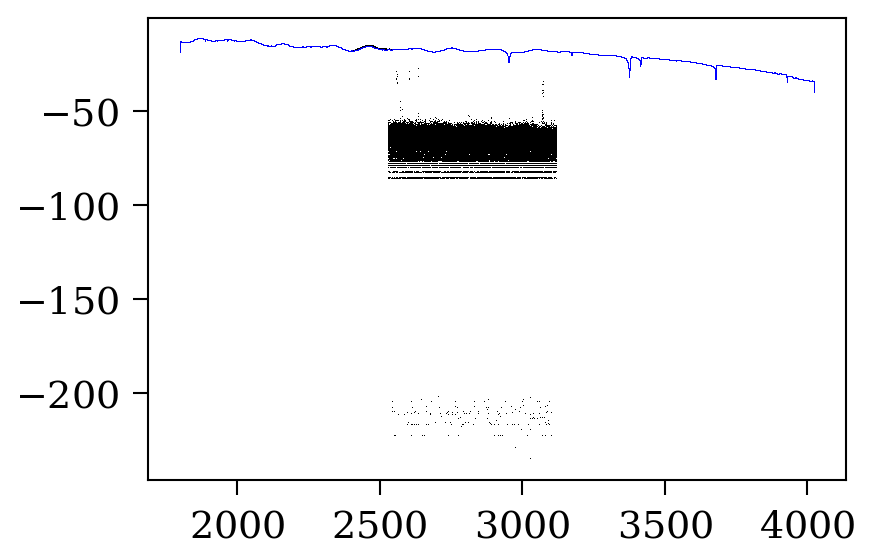

In [8]:
fig, ax = plt.subplots()
for sa in sweeps:
    ax.plot(sa.frequency_MHz, 20 * np.log10(np.abs(sa.s21_point)), ',k')
ax.plot(1e-6 * background['frequency'], 20 * np.log10(background['smoothed']), ',b')


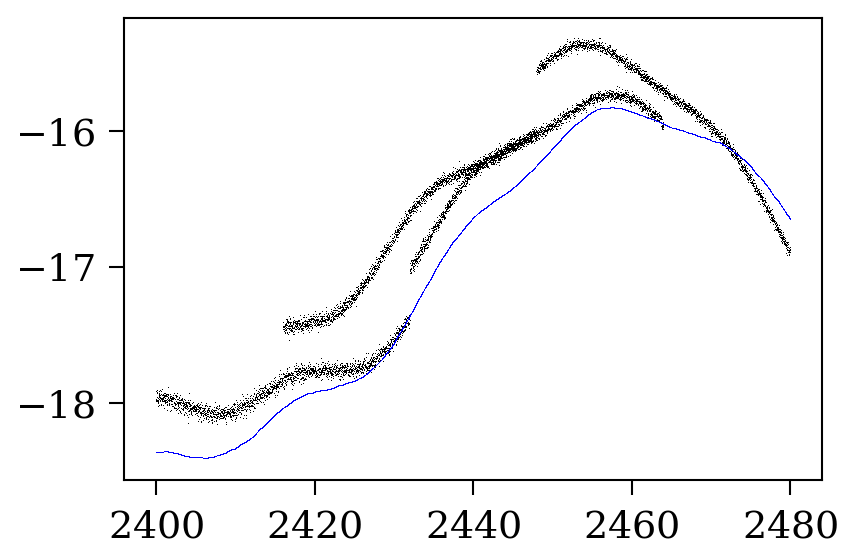

In [9]:
fig, ax = plt.subplots()
for sa in sweeps[:4]:
    start_index = np.searchsorted(background['frequency'], sa.frequency.min())
    f = background['frequency'][start_index:start_index + sa.frequency.size]
    amp = background['smoothed'][start_index:start_index + sa.frequency.size]
    ax.plot(1e-6 * sa.frequency, 20 * np.log10(np.abs(sa.s21_point)), ',k')
    ax.plot(1e-6 * f, 20 * np.log10(amp), ',b')

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


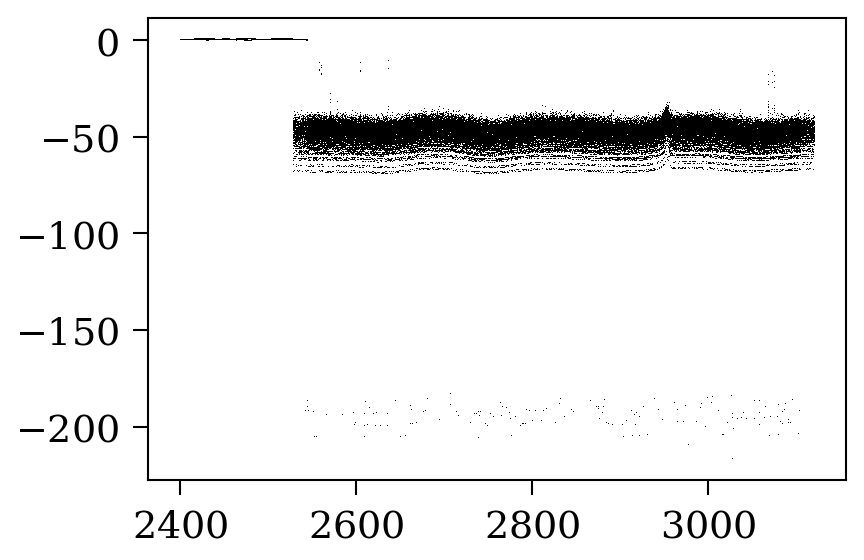

In [10]:
fig, ax = plt.subplots()
for sa in sweeps:
    start_index = np.searchsorted(background['frequency'], sa.frequency.min())
    amp = background['smoothed'][start_index:start_index + sa.frequency.size]
    ax.plot(1e-6 * sa.frequency, 20 * np.log10(np.abs(sa.s21_point) / amp), ',k')
#ax.set_xlim(1800, 2200)
#ax.set_ylim(-2, 2)

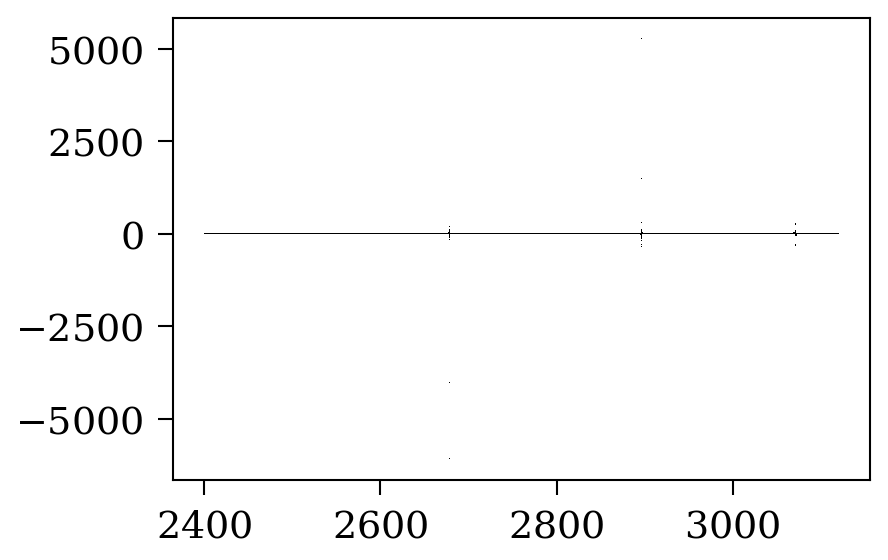

In [11]:
f_full = np.concatenate([sa.frequency_MHz for sa in sweeps])
s21_full = np.concatenate([sa.s21_point for sa in sweeps])
full_poly = np.polyfit(f_full, np.abs(s21_full), deg=4)
fig, ax = plt.subplots()
ax.plot(f_full, np.abs(s21_full) / np.polyval(full_poly, f_full), ',k')

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


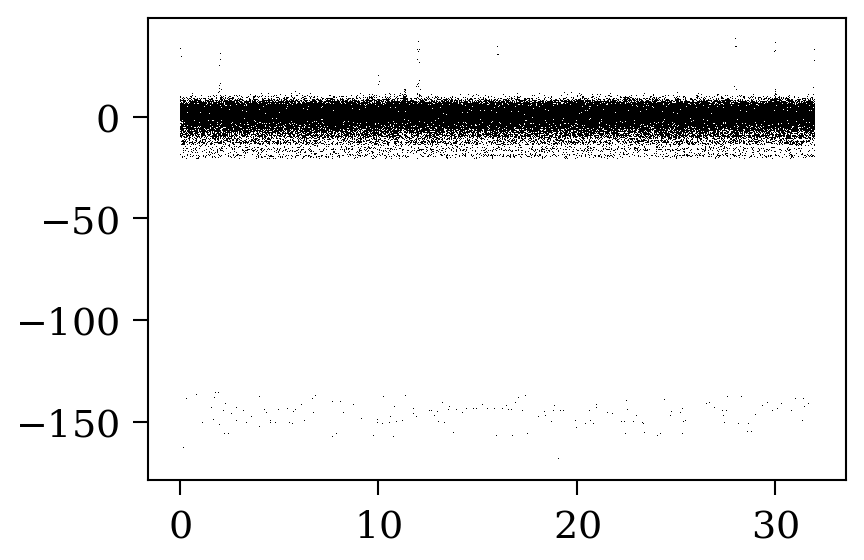

In [12]:
fig, ax = plt.subplots()
for sa in sweeps:
    ax.plot(sa.frequency_MHz - sa.frequency_MHz.min(), 20 * np.log10(np.abs(sa.s21_point) / np.median(np.abs(sa.s21_point))), ',k')

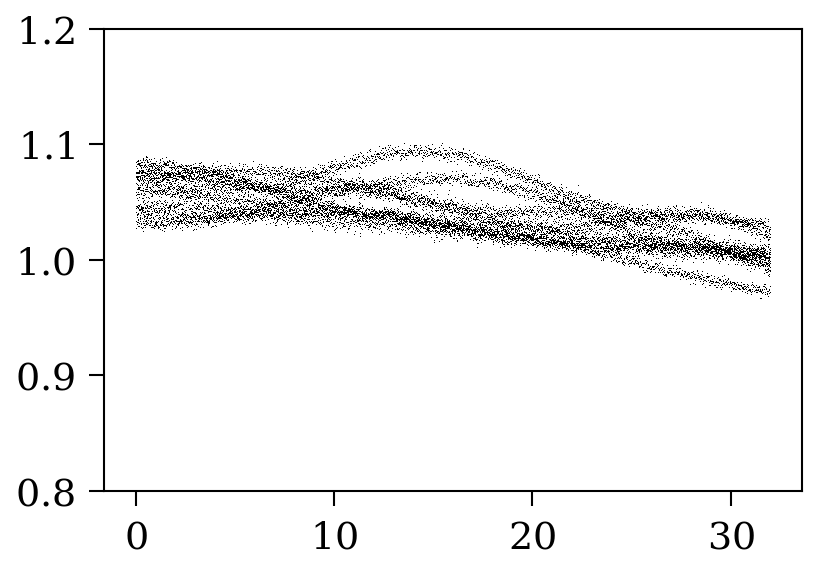

In [ ]:
norms = []
fig, ax = plt.subplots()
for sa in sweeps:
    start_index = np.searchsorted(background['frequency'], sa.frequency.min())
    amp = background['smoothed'][start_index:start_index + sa.frequency.size]
    norm = np.abs(sa.s21_point) / amp
    ax.plot(sa.frequency_MHz - sa.frequency_MHz.min(), norm, ',k')
    norms.append(norm)
stacked = np.stack(norms, axis=0)
stacked_median = np.median(stacked, axis=0)
f = sa.frequency_MHz - sa.frequency_MHz.min()
ax.plot(f, stacked_median, ',r')
stacked_poly = np.polyfit(f, stacked_median, 2)
ax.plot(f, np.polyval(stacked_poly, f), '-b')
ax.set_ylim(0.8, 1.2);

num_subplots = len(sweeps)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.5})
for sa, ax in zip(sweeps, axes.flatten()):
    poly = np.polyfit(sa.frequency_MHz, np.abs(sa.s21_point), deg=4, w=np.abs(sa.s21_point)**2)
    ax.plot(sa.frequency_MHz, 20 * np.log10(np.abs(sa.s21_point)), '-k')
    ax.plot(sa.frequency_MHz, 20 * np.log10(np.polyval(poly, sa.frequency_MHz)), '-r')

num_subplots = len(sweeps)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.5})
for sa, ax in zip(sweeps, axes.flatten()):
    phi = np.unwrap(np.angle(sa.s21_point))
    poly = np.polyfit(sa.frequency_MHz, phi, deg=4, w=np.abs(sa.s21_point)**2)
    ax.plot(sa.frequency_MHz, phi, '-k')
    ax.plot(sa.frequency_MHz, np.polyval(poly, sa.frequency_MHz), '-r')

num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.5})
for sweep, (amp_ax, phi_ax) in zip(sweeps, np.atleast_2d(axes)):
    s21 = remove_background(sweep.frequency_MHz, sweep.s21_point)
    amp_ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(s21)), '-k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(s21), '-k')

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: 

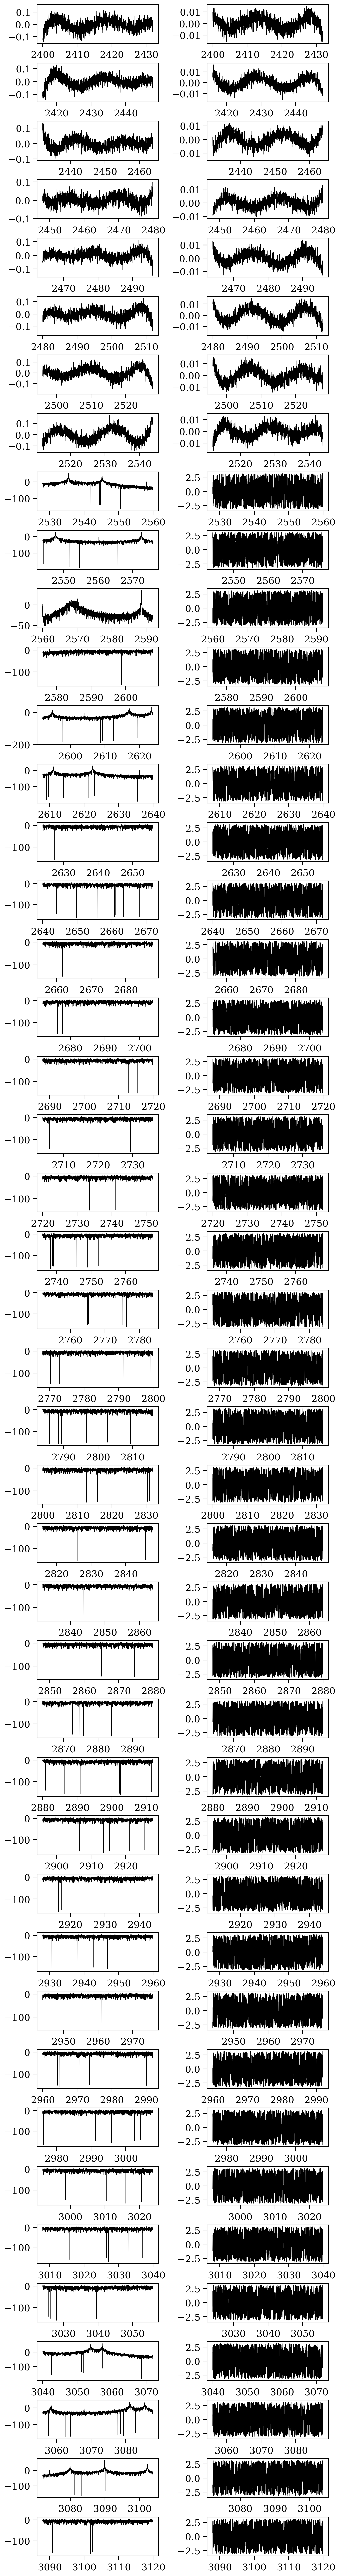

In [ ]:
num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.5})
for sweep, (amp_ax, phi_ax) in zip(sweeps, np.atleast_2d(axes)):
    amp_ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(sweep.s21_point_foreground)), '-k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(sweep.s21_point_foreground), '-k')

# Find resonators

sa = sweeps[32]

res = find_resonators.find_resonators(frequency=f, s21=sa.s21_point_foreground, s21_error=sa.s21_point_error_foreground,
                                      frequency_span=0.8e6, detect_peaks_threshold=0.009, make_plot=True, annotate=False,
                                      detect_peaks_kwargs={})
res

f_scale = 1e-6
Q = 30000
df = f[1] - f[0]
linewidth = f.mean() / Q

width = int(linewidth / df)
x = np.linspace(-4, 4, 8 * width)
kernel = np.exp(-x ** 2)
#kernel = np.sinc(x)
#kernel = 1 / (x**2 + 1)
kernel /= np.sum(kernel)

fig, ax = plt.subplots()
ax.semilogy(df * x, kernel)

phi_smoothed = np.convolve(kernel, phi, mode='same')
#d_phi = np.diff(np.concatenate(([0], phi_smoothed))) / df
d_phi = np.convolve(np.array([1, -1]), phi_smoothed, mode='same')

amp_smoothed = np.convolve(kernel, amp, mode='same')
#d_amp = np.diff(np.concatenate(([0], amp_smoothed))) / df
#d2_amp = np.diff(np.concatenate(([0], d_amp))) / df
d2_amp = np.convolve(np.array([1, -2, 1]), amp_smoothed, mode='same')

merit = d_phi * d2_amp

fig, ax = plt.subplots()
d_ax = ax.twinx()
ax.plot(f_scale * f, 20 * np.log10(amp_smoothed / amp_smoothed.mean()), '-', color='gray')
ax.plot(f_scale * f, phi_smoothed, '-', color='black')
d_ax.plot(f_scale * f[width:-width], d_phi[width:-width], '-', color='red', alpha=0.5)
d_ax.plot(f_scale * f[width:-width], d2_amp[width:-width] / amp_smoothed.mean(), '-', color='blue', alpha=0.5)
#d_ax.plot(f_scale * f[width:-width], 100 * merit[width:-width], '-', color='green')
#ax.set_xlim(2608, 2610)

# Wavelets

In [ ]:
# Custom wavelet for phase
def odd_wavelet(points, a):
    x = (np.arange(points) - points / 2) / a
    return x * np.exp(-x**2 / 2)

def odd_kernel(points, a):
    x = (np.arange(points) - points / 2) / a
    result = np.zeros(points)
    result[x != 0] = -x[x != 0]**-1
    return result

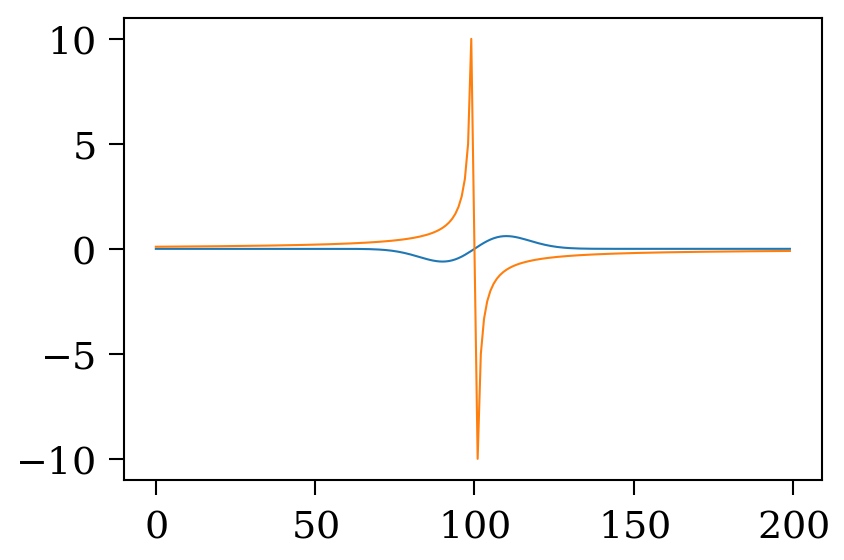

In [ ]:
fig, ax = plt.subplots()
ax.plot(odd_wavelet(200, 10))
ax.plot(odd_kernel(200, 10))

In [ ]:
sa = sweeps[10]
f = sa.frequency
s21 = sa.s21_point_foreground
amp = np.abs(s21)
phi = np.unwrap(np.angle(s21))
Q = 20000
linewidth = np.round(f.mean() / (Q * (f[1] - f[0])))  # in points

n_widths = 100
snr = 1
widths = np.logspace(np.log10(linewidth) - 1, np.log10(linewidth) + 1, n_widths)

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [ ]:
amp_x = np.linspace(-4, 4, 8 * linewidth)
amp_kernel = np.exp(-amp_x ** 2)
i_amp = (1 / amp - 1)
i_amp_smoothed = np.convolve(amp_kernel, i_amp, mode='same')
amp_threshold = 0.1 * np.std(i_amp_smoothed)
amp_peaks = signal.find_peaks_cwt(vector=i_amp_smoothed, widths=widths, min_snr=snr)
amp_peak_mask = (amp_peaks > linewidth) & (amp_peaks < f.size - linewidth) & (i_amp[amp_peaks] > amp_threshold)

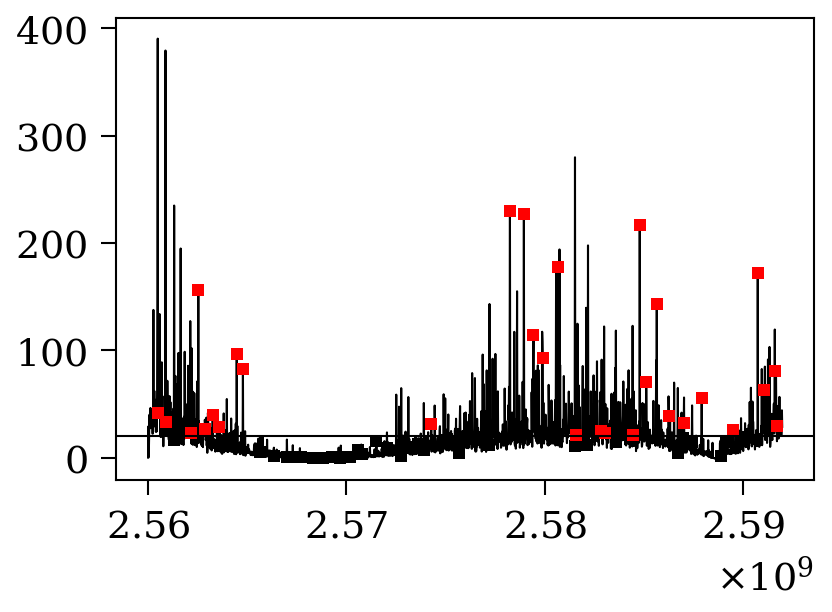

In [ ]:
fig, ax = plt.subplots()
ax.plot(f, i_amp, '-', color='black')
ax.plot(f[amp_peaks], i_amp[amp_peaks], 's', color='black')
ax.plot(f[amp_peaks][amp_peak_mask], i_amp[amp_peaks][amp_peak_mask], 's', color='red')
ax.axhline(amp_threshold, color='black')

In [ ]:
fig, amp_ax = plt.subplots()
amp_ax.plot(f, amp, '-', color='black')
amp_ax.plot(f[amp_peaks], amp[amp_peaks], 's', color='black')
amp_ax.plot(f[amp_peaks][amp_peak_mask], amp[amp_peaks][amp_peak_mask], 's', color='red')

In [ ]:
phi_kernel = odd_kernel(10 * int(linewidth), int(linewidth))
phi_convolved = np.convolve(phi_kernel, phi, mode='same')
phi_threshold = 0.5 * np.std(phi_convolved)
phi_peaks = signal.find_peaks_cwt(vector=phi_convolved, widths=widths, min_snr=snr)
phi_peak_mask = (phi_peaks > linewidth) & (phi_peaks < f.size - linewidth) & (phi_convolved[phi_peaks] > phi_threshold)

In [ ]:
fig, ax = plt.subplots()
ax.plot(f, phi_convolved, '-', color='gray')
ax.plot(f[phi_peaks], phi_convolved[phi_peaks], 'o', color='black')
ax.plot(f[phi_peaks][phi_peak_mask], phi_convolved[phi_peaks][phi_peak_mask], 's', color='blue')
ax.axhline(phi_threshold, color='gray')

In [ ]:
fig, ax = plt.subplots()
ax.plot(f, phi, '-', color='black')
ax.plot(f[phi_peaks], phi[phi_peaks], 's', color='black')
ax.plot(f[phi_peaks][phi_peak_mask], phi[phi_peaks][phi_peak_mask], 's', color='red')
ax.plot(f[:phi_kernel.size], phi_kernel * phi.max() / phi_kernel.max(), '-r')

In [ ]:
cwt = signal.cwt(phi, wavelet=odd_wavelet, widths=widths)

fig, ax = plt.subplots()
ax.imshow(cwt, aspect='auto', origin='lower', extent=(f.min(), f.max(), widths.min(), widths.max()))

# SweepArray

In [ ]:
sa = sweeps[10]
peaks = sa.find_resonances(min_snr=0.1)
rs = [sa.resonator(frequency=sa.frequency[peak], width=10 * sa.frequency.mean() / Q,
                   model=lmfit_resonator.LinearLossResonatorWithCable)
      for peak in peaks]
fig, ax = plt.subplots()
ax.plot(sa.frequency_MHz, np.abs(sa.s21_point_foreground))
for r in rs:
    plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)
ax.plot(sa.frequency_MHz[peaks], np.abs(sa.s21_point_foreground[peaks]), '.')


In [ ]:
def fit_and_plot(sa, ax, min_snr=0.5, Q=30000, num_linewidths=10, threshold=1):
    peaks = sa.find_resonances(min_snr=min_snr, threshold=threshold)
    rs = [sa.resonator(frequency=sa.frequency[peak], width=num_linewidths * sa.frequency.mean() / Q,
                       model=lmfit_resonator.LinearLossResonatorWithCable)
          for peak in peaks]
    ax.plot(sa.frequency_MHz, np.abs(sa.s21_point_foreground))
    ax.plot(sa.frequency_MHz[peaks], np.abs(sa.s21_point_foreground[peaks]), '.')
    for r in rs:
        plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)

In [ ]:
num_subplots = len(sweeps)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.5})
for sa, ax in zip(sweeps, np.atleast_1d(axes).flatten()):
    fit_and_plot(sa, ax, min_snr=0.1, threshold=2)